# Customer Lifetime Value With Buy Till You Die Models

In [1]:
# Import Important Libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from pymc_marketing import clv

In [3]:
#Import and preprocess dataset
df = pd.read_csv("uk_dataset_full.csv")
df.columns = df.columns.str.replace(' ', '')
df.rename(columns={"Price":"UnitPrice"},inplace=True)
df.head(5)

,Unnamed:0,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
#Remove return orders and cancelled orders
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
data_raw = df.copy()
cancelled_orders = data_raw[data_raw['Invoice'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['Invoice'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

# Selecting relevant features and calculating total sales
features = ['CustomerID', 'Invoice', 'StockCode','InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,Invoice,StockCode,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,13085,489434,85048,2009-12-01 07:45:00,12,6.95,United Kingdom,83.4
1,13085,489434,79323P,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
2,13085,489434,79323W,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
3,13085,489434,22041,2009-12-01 07:45:00,48,2.10,United Kingdom,100.8
4,13085,489434,21232,2009-12-01 07:45:00,24,1.25,United Kingdom,30.0


In [5]:
#RFM-T Summary
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12346,12346,7.0,400.0,725.0,11066.637143
12347,12347,7.0,402.0,404.0,717.398571
12348,12348,4.0,363.0,438.0,449.310000
12349,12349,3.0,571.0,589.0,1120.056667
12350,12350,0.0,0.0,310.0,0.000000


In [6]:
summary = data_summary_rfm.copy()

In [7]:
# Using lifetimes library
# Fit the BG/NBD model
from lifetimes import BetaGeoFitter, GammaGammaFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.0)
positive_monetary_summary = summary[summary['monetary_value'] > 0]
ggf.fit(positive_monetary_summary['frequency'], positive_monetary_summary['monetary_value'])

# Calculate CLV
positive_monetary_summary['clv'] = ggf.customer_lifetime_value(
    bgf, 
    positive_monetary_summary['frequency'], 
    positive_monetary_summary['recency'], 
    positive_monetary_summary['T'], 
    positive_monetary_summary['monetary_value'], 
    time=12, 
    discount_rate=0.01
)
positive_monetary_summary.head(5)

,customer_id,frequency,recency,T,monetary_value,clv
customer_id,,,,,,
12346,12346,7.0,400.0,725.0,11066.637143,17428.703142
12347,12347,7.0,402.0,404.0,717.398571,3565.724058
12348,12348,4.0,363.0,438.0,449.310000,1289.950710
12349,12349,3.0,571.0,589.0,1120.056667,1659.463543
12352,12352,8.0,356.0,392.0,338.261250,2113.710611


In [8]:
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Assuming `summary` is your aggregated data with the necessary columns

# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit the Gamma-Gamma model for monetary value
ggf = GammaGammaFitter(penalizer_coef=0.0)
positive_monetary_summary = summary[summary['monetary_value'] > 0]
ggf.fit(positive_monetary_summary['frequency'], positive_monetary_summary['monetary_value'])

# Calculate CLV for customers with positive monetary values
positive_monetary_summary['clv'] = ggf.customer_lifetime_value(
    bgf, 
    positive_monetary_summary['frequency'], 
    positive_monetary_summary['recency'], 
    positive_monetary_summary['T'], 
    positive_monetary_summary['monetary_value'], 
    time=12, 
    discount_rate=0.01
)

# Calculate the probability that a customer is alive
summary['probability_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)

# Calculate the expected number of purchases in the next 30 days (or any given period)
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, 
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)

summary.head()

,customer_id,frequency,recency,T,monetary_value,probability_alive,predicted_purchases
customer_id,,,,,,,
12346,12346,7.0,400.0,725.0,11066.637143,0.568660,0.165547
12347,12347,7.0,402.0,404.0,717.398571,0.986837,0.484073
12348,12348,4.0,363.0,438.0,449.310000,0.959046,0.266931
12349,12349,3.0,571.0,589.0,1120.056667,0.973475,0.163673
12350,12350,0.0,0.0,310.0,0.000000,1.000000,0.053127


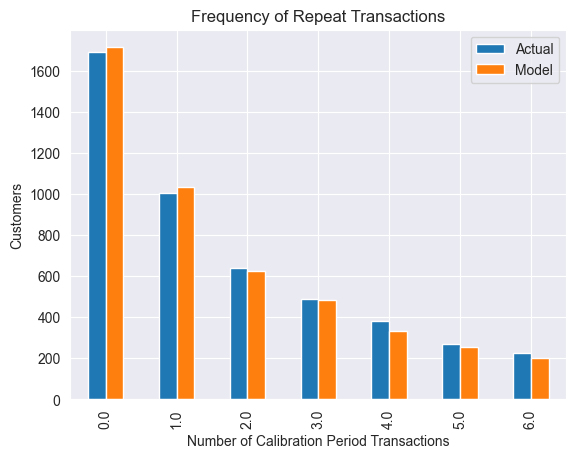

In [9]:
from lifetimes.plotting import plot_period_transactions

# Plot the expected number of transactions in future periods
plot_period_transactions(bgf);

In [10]:
from lifetimes.utils import calibration_and_holdout_data

# Split data into calibration and holdout periods
summary_cal_holdout = calibration_and_holdout_data(
    data, 'CustomerID', 'InvoiceDate',
    calibration_period_end='2011-09-01',
    observation_period_end='2011-12-09'  # Adjust dates based on your dataset
)

# Fit the model on the calibration data
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# Predict future transactions
summary_cal_holdout['predicted_purchases'] = bgf.predict(
    120,  # Predict for the next 120 days (or any appropriate period)
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)

# Compare actual vs. predicted transactions
print(summary_cal_holdout[['frequency_holdout', 'predicted_purchases']])


In [11]:
# Add a column with actual CLV for comparison
positive_monetary_summary['actual_clv'] = positive_monetary_summary['monetary_value'] * positive_monetary_summary['frequency']

# Compare predicted CLV with actual CLV
print(positive_monetary_summary[['clv', 'actual_clv']])


                      clv  actual_clv
customer_id                          
12346        17428.703142    77466.46
12347         3565.724058     5021.79
12348         1289.950710     1797.24
12349         1659.463543     3360.17
12352         2113.710611     2706.09
...                   ...         ...
18281          206.869918       80.82
18282          692.588159       77.84
18283         1382.159756     2635.30
18286          349.990181      833.48
18287         1671.359282     3111.38

[4189 rows x 2 columns]


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE for predicted purchases
mae_purchases = mean_absolute_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])
rmse_purchases = np.sqrt(mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

# Calculate MAE and RMSE for CLV
mae_clv = mean_absolute_error(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv'])
rmse_clv = np.sqrt(mean_squared_error(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv']))

print(f"MAE for purchases: {mae_purchases}")
print(f"RMSE for purchases: {rmse_purchases}")
print(f"MAE for CLV: {mae_clv}")
print(f"RMSE for CLV: {rmse_clv}")


MAE for purchases: 0.7357286590304736
RMSE for purchases: 1.1932282962710532
MAE for CLV: 2028.645437414024
RMSE for CLV: 10107.371634205367


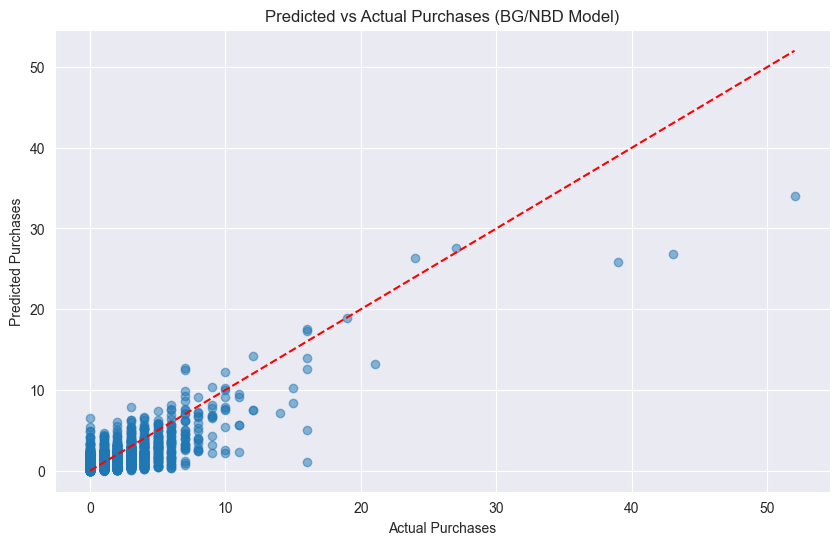

In [13]:
import matplotlib.pyplot as plt

# Plotting Predicted vs Actual Transactions
plt.figure(figsize=(7, 5))
plt.scatter(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'], alpha=0.5)
plt.plot([0, max(summary_cal_holdout['frequency_holdout'])], [0, max(summary_cal_holdout['frequency_holdout'])], color='red', linestyle='--')
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Predicted vs Actual Purchases (BG/NBD Model)')
plt.show()


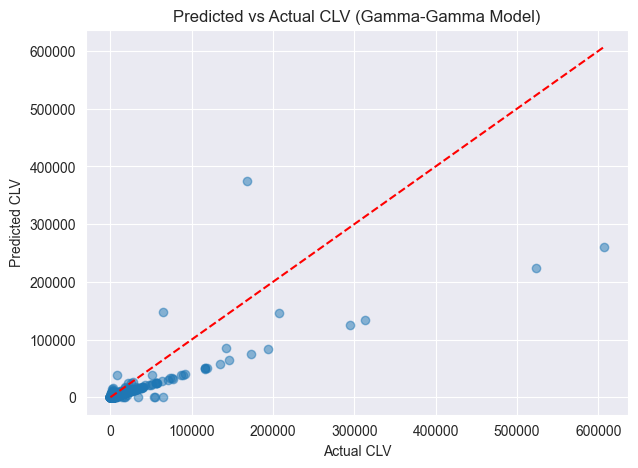

In [25]:
# Plotting Predicted vs Actual CLV
plt.figure(figsize=(7, 5))
plt.scatter(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv'], alpha=0.5)
plt.plot([0, max(positive_monetary_summary['actual_clv'])], [0, max(positive_monetary_summary['actual_clv'])], color='red', linestyle='--')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Predicted vs Actual CLV (Gamma-Gamma Model)')
plt.show()


In [ ]:
# More refined queries

BG/NBD Penalizer: 0.0, MAE: 0.7357286590304736, RMSE: 1.1932282962710532
BG/NBD Penalizer: 0.01, MAE: 0.7383583609774964, RMSE: 1.1911793625534763
BG/NBD Penalizer: 0.1, MAE: 0.7335751294064827, RMSE: 1.1765791523821598
BG/NBD Penalizer: 1.0, MAE: 0.737995321806193, RMSE: 1.186228434171614
BG/NBD Penalizer: 10.0, MAE: 0.7417505847116257, RMSE: 1.2078405847661224
Best BG/NBD Penalizer: 0.1, Best MAE: 0.7335751294064827, Best RMSE: 1.1765791523821598
Gamma-Gamma Penalizer: 0.0, MAE: 1991.4298467806798, RMSE: 9924.92675373032
Gamma-Gamma Penalizer: 0.01, MAE: 1984.8780408073499, RMSE: 10228.373741898455
Gamma-Gamma Penalizer: 0.1, MAE: 2649.4164914538014, RMSE: 23406.751264823633
Gamma-Gamma Penalizer: 1.0, MAE: 3773.436733060116, RMSE: 13004.927445237443
Gamma-Gamma Penalizer: 10.0, MAE: 5320.849826804171, RMSE: 15799.628822780523
Best Gamma-Gamma Penalizer: 0.01, Best MAE: 1984.8780408073499, Best RMSE: 10228.373741898455


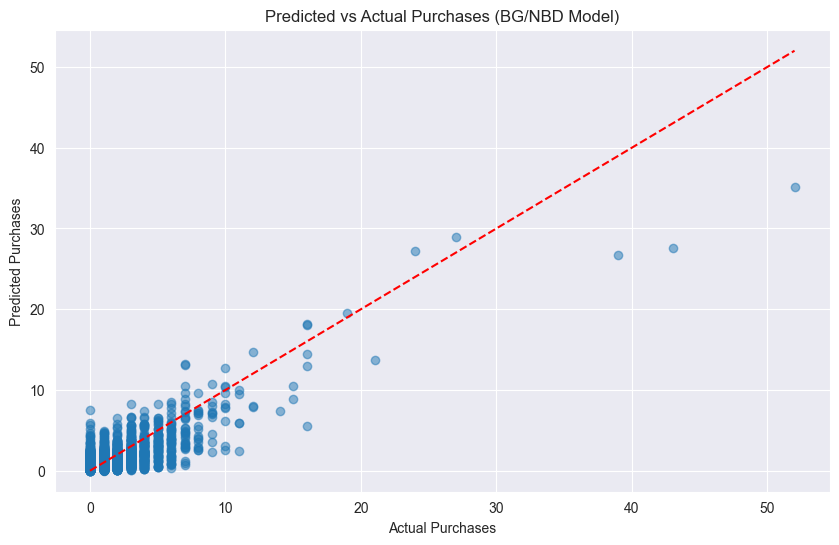

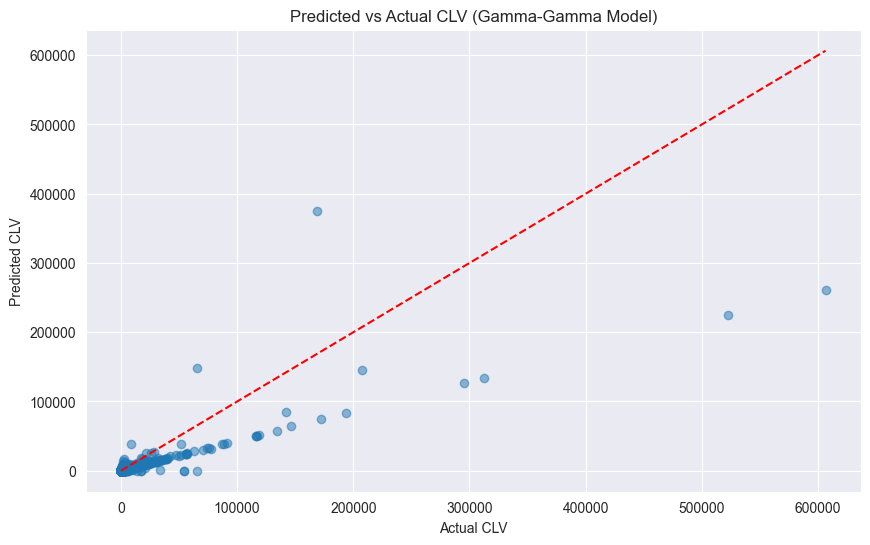

In [23]:
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv("uk_dataset_full.csv")
df.columns = df.columns.str.replace(' ', '')
df.rename(columns={"Price": "UnitPrice"}, inplace=True)

# Remove return orders and cancelled orders
data_raw = df.copy()
cancelled_orders = data_raw[data_raw['Invoice'].astype(str).str.startswith("C")]
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['Invoice'].astype(str).str.startswith("C"))]
data_raw = data_raw.drop(columns=['_merge'])

# Selecting relevant features and calculating total sales
features = ['CustomerID', 'Invoice', 'StockCode', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)

# RFM-T Summary
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
summary = data_summary_rfm.copy()

# Function to evaluate BG/NBD model
def evaluate_bgnbd(penalizer_coef):
    bgf = BetaGeoFitter(penalizer_coef=penalizer_coef)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    
    # Split data into calibration and holdout periods
    summary_cal_holdout = calibration_and_holdout_data(
        data, 'CustomerID', 'InvoiceDate',
        calibration_period_end='2011-09-01',
        observation_period_end='2011-12-09'
    )
    
    # Fit the model on the calibration data
    bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
    
    # Predict future transactions
    summary_cal_holdout['predicted_purchases'] = bgf.predict(
        120,
        summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal']
    )
    
    # Drop NaN values
    summary_cal_holdout = summary_cal_holdout.dropna(subset=['frequency_holdout', 'predicted_purchases'])
    
    # Calculate MAE and RMSE for predicted purchases
    mae_purchases = mean_absolute_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])
    rmse_purchases = np.sqrt(mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
    
    return mae_purchases, rmse_purchases, bgf

# Function to evaluate Gamma-Gamma model
def evaluate_gammagamma(penalizer_coef, bgf):
    ggf = GammaGammaFitter(penalizer_coef=penalizer_coef)
    positive_monetary_summary = summary[summary['monetary_value'] > 0]
    ggf.fit(positive_monetary_summary['frequency'], positive_monetary_summary['monetary_value'])
    
    # Calculate CLV for customers with positive monetary values
    positive_monetary_summary['clv'] = ggf.customer_lifetime_value(
        bgf, 
        positive_monetary_summary['frequency'], 
        positive_monetary_summary['recency'], 
        positive_monetary_summary['T'], 
        positive_monetary_summary['monetary_value'], 
        time=12, 
        discount_rate=0.01
    )
    
    # Calculate actual CLV
    positive_monetary_summary['actual_clv'] = positive_monetary_summary['monetary_value'] * positive_monetary_summary['frequency']
    
    # Drop NaN values
    positive_monetary_summary = positive_monetary_summary.dropna(subset=['clv', 'actual_clv'])
    
    # Calculate MAE and RMSE for CLV
    mae_clv = mean_absolute_error(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv'])
    rmse_clv = np.sqrt(mean_squared_error(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv']))
    
    return mae_clv, rmse_clv

# Grid search for BG/NBD model
penalizer_coefs = [0.0, 0.01, 0.1, 1.0, 10.0]
best_mae_purchases, best_rmse_purchases = float('inf'), float('inf')
best_bgf_penalizer = None
best_bgf = None

for penalizer_coef in penalizer_coefs:
    mae_purchases, rmse_purchases, bgf = evaluate_bgnbd(penalizer_coef)
    print(f'BG/NBD Penalizer: {penalizer_coef}, MAE: {mae_purchases}, RMSE: {rmse_purchases}')
    if mae_purchases < best_mae_purchases:
        best_mae_purchases = mae_purchases
        best_rmse_purchases = rmse_purchases
        best_bgf_penalizer = penalizer_coef
        best_bgf = bgf

print(f'Best BG/NBD Penalizer: {best_bgf_penalizer}, Best MAE: {best_mae_purchases}, Best RMSE: {best_rmse_purchases}')

# Grid search for Gamma-Gamma model
best_mae_clv, best_rmse_clv = float('inf'), float('inf')
best_ggf_penalizer = None

for penalizer_coef in penalizer_coefs:
    mae_clv, rmse_clv = evaluate_gammagamma(penalizer_coef, best_bgf)
    print(f'Gamma-Gamma Penalizer: {penalizer_coef}, MAE: {mae_clv}, RMSE: {rmse_clv}')
    if mae_clv < best_mae_clv:
        best_mae_clv = mae_clv
        best_rmse_clv = rmse_clv
        best_ggf_penalizer = penalizer_coef

print(f'Best Gamma-Gamma Penalizer: {best_ggf_penalizer}, Best MAE: {best_mae_clv}, Best RMSE: {best_rmse_clv}')

# Refit models with best penalizer coefficients
best_bgf = BetaGeoFitter(penalizer_coef=best_bgf_penalizer)
best_bgf.fit(summary['frequency'], summary['recency'], summary['T'])

best_ggf = GammaGammaFitter(penalizer_coef=best_ggf_penalizer)
positive_monetary_summary = summary[summary['monetary_value'] > 0]
best_ggf.fit(positive_monetary_summary['frequency'], positive_monetary_summary['monetary_value'])

# Calculate CLV with best models
positive_monetary_summary['clv'] = best_ggf.customer_lifetime_value(
    best_bgf, 
    positive_monetary_summary['frequency'], 
    positive_monetary_summary['recency'], 
    positive_monetary_summary['T'], 
    positive_monetary_summary['monetary_value'], 
    time=12, 
    discount_rate=0.01
)

# Calculate actual CLV
positive_monetary_summary['actual_clv'] = positive_monetary_summary['monetary_value'] * positive_monetary_summary['frequency']

# Split data into calibration and holdout periods for final plotting
summary_cal_holdout = calibration_and_holdout_data(
    data, 'CustomerID', 'InvoiceDate',
    calibration_period_end='2011-09-01',
    observation_period_end='2011-12-09'
)
summary_cal_holdout['predicted_purchases'] = best_bgf.predict(
    120,
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)
summary_cal_holdout = summary_cal_holdout.dropna(subset=['frequency_holdout', 'predicted_purchases'])

# Plotting Predicted vs Actual Purchases
plt.figure(figsize=(10, 6))
plt.scatter(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'], alpha=0.5)
plt.plot([0, max(summary_cal_holdout['frequency_holdout'])], [0, max(summary_cal_holdout['frequency_holdout'])], color='red', linestyle='--')
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Predicted vs Actual Purchases (BG/NBD Model)')
plt.show()

# Plotting Predicted vs Actual CLV
plt.figure(figsize=(10, 6))
plt.scatter(positive_monetary_summary['actual_clv'], positive_monetary_summary['clv'], alpha=0.5)
plt.plot([0, max(positive_monetary_summary['actual_clv'])], [0, max(positive_monetary_summary['actual_clv'])], color='red', linestyle='--')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Predicted vs Actual CLV (Gamma-Gamma Model)')
plt.show()


In [16]:
df2 = df[["Invoice","StockCode","Quantity","InvoiceDate","UnitPrice","CustomerID"]]


In [23]:
df2["TotalAmount"] = df2["UnitPrice"].multiply(df2["Quantity"])
df2 = df2[["Invoice","StockCode","InvoiceDate","TotalAmount","CustomerID"]]
df2.head(5)

KeyError: 'UnitPrice'

In [18]:
from lifetimes import GammaGammaFitter
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data

# create summary data from transaction data
summary1 = summary_data_from_transaction_data(df2, 
                                             customer_id_col = 'CustomerID', 
                                             datetime_col = 'InvoiceDate', 
                                             monetary_value_col='TotalAmount',
                                             observation_period_end = max(df["InvoiceDate"]))

summary1 = summary[summary["monetary_value"] > 0]

# fit the BG/NBD model
bgf1 = BetaGeoFitter(penalizer_coef=0.0)
bgf1.fit(summary1['frequency'], summary1['recency'], summary1['T'])

# fit the Gamma-Gamma submodel
ggf1 = GammaGammaFitter(penalizer_coef=0.0)
ggf1.fit(summary1['frequency'], summary1['monetary_value'])


# predict customer lifetime value
summary1['predicted_purchases'] = bgf1.predict(30, summary1['frequency'], summary1['recency'], summary1['T'])
summary1['predicted_clv'] = ggf1.customer_lifetime_value(bgf1, 
                                                       summary1['frequency'],
                                                       summary1['recency'],
                                                       summary1['T'],
                                                       summary1['monetary_value'],
                                                       time=1, #the lifetime expected for the user in months
                                                       freq='D', 
                                                       discount_rate=0.01)
# Calculate the probability that a customer is alive
summary1['probability_alive'] = bgf1.conditional_probability_alive(
    summary1['frequency'], 
    summary1['recency'], 
    summary1['T']
)
summary1["estimated_monetary_value"] = ggf1.conditional_expected_average_profit(
        summary1['frequency'],
        summary1['monetary_value']
    )
summary1.head()

,customer_id,frequency,recency,T,monetary_value,probability_alive,predicted_purchases,predicted_clv,estimated_monetary_value
customer_id,,,,,,,,,
12346,12346,6.0,196.0,725.0,47.143333,0.027372,0.007436,0.802201,108.965567
12347,12347,7.0,402.0,404.0,717.398571,0.985006,0.493399,326.902751,669.177443
12348,12348,4.0,363.0,438.0,449.310000,0.945076,0.287806,124.814006,438.010354
12349,12349,3.0,571.0,589.0,1120.056667,0.963288,0.188220,169.062597,907.200679
12352,12352,7.0,356.0,392.0,229.332857,0.972810,0.499004,126.379340,255.795981


In [ ]:
# Results Interpretation:
# predicted_purchases: The expected number of future purchases in a specified period (e.g., next 30 days).
# predicted_clv: The estimated lifetime value of a customer over a specified period (e.g., 1 month).
# probability_alive: The likelihood that the customer is still active and will make future purchases.
# estimated_monetary_value: The expected average profit from each transaction for the customer.

In [ ]:
# Provided Metrics:
# Customer ID: 15117\n
# Frequency: 5.0
# Recency: 620.0
# Age (T): 634.0
# Monetary Value: 424.926
# Probability Alive: 0.977284
# Predicted Purchases: 0.2585
# Predicted CLV: 107.585076
# Estimated Monetary Value: 420.352535
# Interpretation:
# Customer ID 15117:
# 
# The unique identifier for the customer in the dataset.
# Frequency (5.0):
# 
# This customer has made 5 purchases during the observation period.
# Recency (620.0):
# 
# The number of days since the customer's last purchase. Given that the age of the customer is 634.0 days, it indicates that this customer made their last purchase relatively recently compared to their entire history with the business.
# Age (T) (634.0):
# 
# The number of days since the customer's first purchase.
# Monetary Value (424.926):
# 
# The average transaction value for this customer is approximately $424.93.
# Probability Alive (0.977284):
# 
# There is a 97.73% probability that this customer is still active and likely to make future purchases. This high probability suggests that the customer is very engaged and loyal.
# Predicted Purchases (0.2585):
# 
# The customer is expected to make approximately 0.2585 purchases in the next 30 days. This value, while less than 1, still indicates some likelihood of future purchases within the next month.
# Predicted CLV (107.585076):
# 
# The expected customer lifetime value over the next month is approximately $107.59. This metric takes into account the frequency of purchases, recency, and monetary value, providing an estimate of the revenue this customer is expected to generate in the near future.
# Estimated Monetary Value (420.352535):
# 
# The expected average profit per transaction for this customer is approximately $420.35. This indicates that when the customer makes a purchase, it is usually of high value.

In [21]:
import pandas as pd
from sqlalchemy import create_engine

# Define your database connection parameters
db_user = 'root'
db_password = '12345'
db_host = 'localhost'
db_name = 'sales_data'

# Create the connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Define your query
query = "SELECT * FROM invoices"

# Load data into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Display the first 5 rows of the DataFrame
df.head(5)


,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,TotalPrice
0,2009-12-01,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,83.4
1,2009-12-01,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,81.0
2,2009-12-01,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,81.0
3,2009-12-01,489434,22041,"RECORD FRAME 7"" SINGLE SIZE """,48,2.10,13085.0,100.8
4,2009-12-01,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,30.0


In [18]:
import pandas as pd
from lifetimes.utils import calibration_and_holdout_data

# Assume `data` is your transaction data
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Split the data into calibration and holdout periods
calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end='2011-12-09',  # Replace with your actual date
                                                   observation_period_end=max(data["InvoiceDate"]))

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]


In [19]:
import pandas as pd
from lifetimes.utils import calibration_and_holdout_data

# Assume `data` is your transaction data
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Split the data into calibration and holdout periods
calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end='2011-12-09',  # Replace with your actual date
                                                   observation_period_end=max(data["InvoiceDate"]))

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]


In [20]:
# Predict the number of purchases for the holdout period
holdout_summary['predicted_purchases'] = bgf.predict(holdout_summary['duration_holdout'], 
                                                     holdout_summary['frequency_cal'], 
                                                     holdout_summary['recency_cal'], 
                                                     holdout_summary['T_cal'])

# Predict the customer lifetime value for the holdout period
holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                               holdout_summary['frequency_cal'], 
                                                               holdout_summary['recency_cal'], 
                                                               holdout_summary['T_cal'], 
                                                               holdout_summary['monetary_value_cal'], 
                                                               time=12,  # The lifetime expected for the user in months
                                                               discount_rate=0.01)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate accuracy metrics for the number of purchases
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
rmse_purchases = mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'], squared=False)
mape_purchases = mean_absolute_percentage_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])

# Calculate accuracy metrics for the customer lifetime value
mae_clv = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
rmse_clv = mean_squared_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'], squared=False)
mape_clv = mean_absolute_percentage_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])

print(f'MAE for purchases: {mae_purchases}')
print(f'RMSE for purchases: {rmse_purchases}')
print(f'MAPE for purchases: {mape_purchases}')

print(f'MAE for CLV: {mae_clv}')
print(f'RMSE for CLV: {rmse_clv}')
print(f'MAPE for CLV: {mape_clv}')


MAE for purchases: 1.0
RMSE for purchases: 1.0
MAPE for purchases: 1.0
MAE for CLV: 14404.477745307602
RMSE for CLV: 44393.14456587031
MAPE for CLV: 377.4775382855062


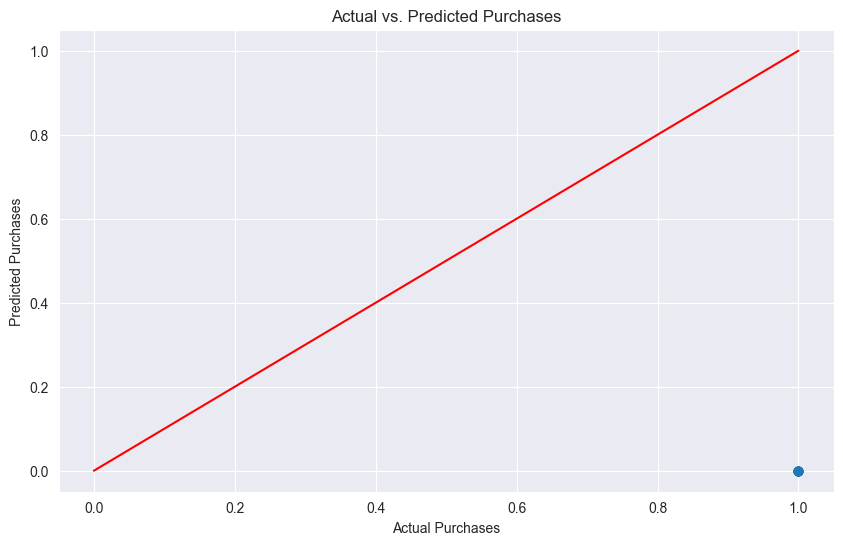

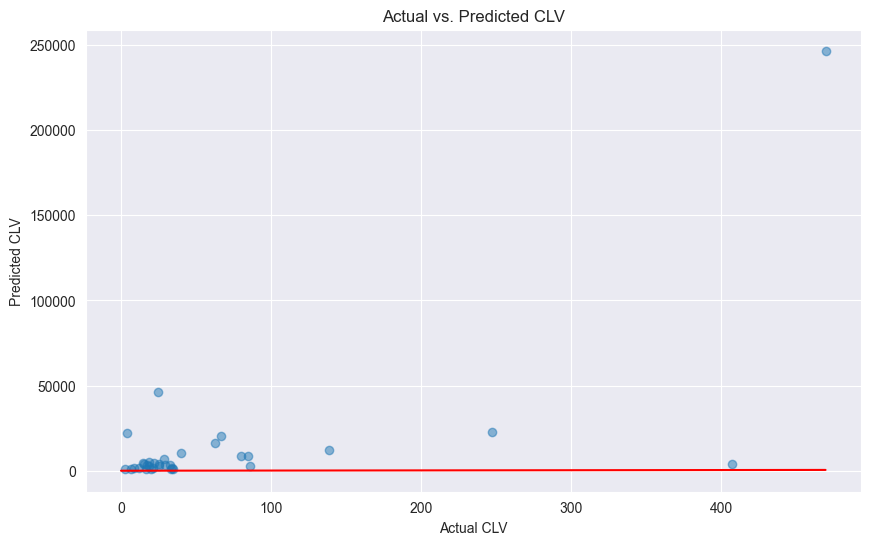

In [22]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual purchases
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'], alpha=0.5)
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Actual vs. Predicted Purchases')
plt.plot([0, max(holdout_summary['frequency_holdout'])], [0, max(holdout_summary['frequency_holdout'])], color='red')
plt.show()

# Plot predicted vs. actual CLV
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'], alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.plot([0, max(holdout_summary['monetary_value_holdout'])], [0, max(holdout_summary['monetary_value_holdout'])], color='red')
plt.show()


         frequency      recency            T  monetary_value  \
count  5849.000000  5849.000000  5849.000000     5849.000000   
mean      4.595657   273.454608   474.084972      284.737552   
std       9.881451   258.721251   223.275102      463.952684   
min       0.000000     0.000000     0.000000        0.000000   
25%       0.000000     0.000000   312.000000        0.000000   
50%       2.000000   221.000000   530.000000      212.583333   
75%       5.000000   511.000000   668.000000      376.086667   
max     245.000000   738.000000   738.000000    14996.500000   

       probability_alive  predicted_purchases  
count       5.849000e+03         5.849000e+03  
mean        9.118857e-01         2.647324e-01  
std         1.691035e-01         4.005007e-01  
min         2.450537e-10         3.362609e-10  
25%         9.288782e-01         6.023233e-02  
50%         9.750723e-01         1.529149e-01  
75%         1.000000e+00         3.226105e-01  
max         1.000000e+00         9.1645

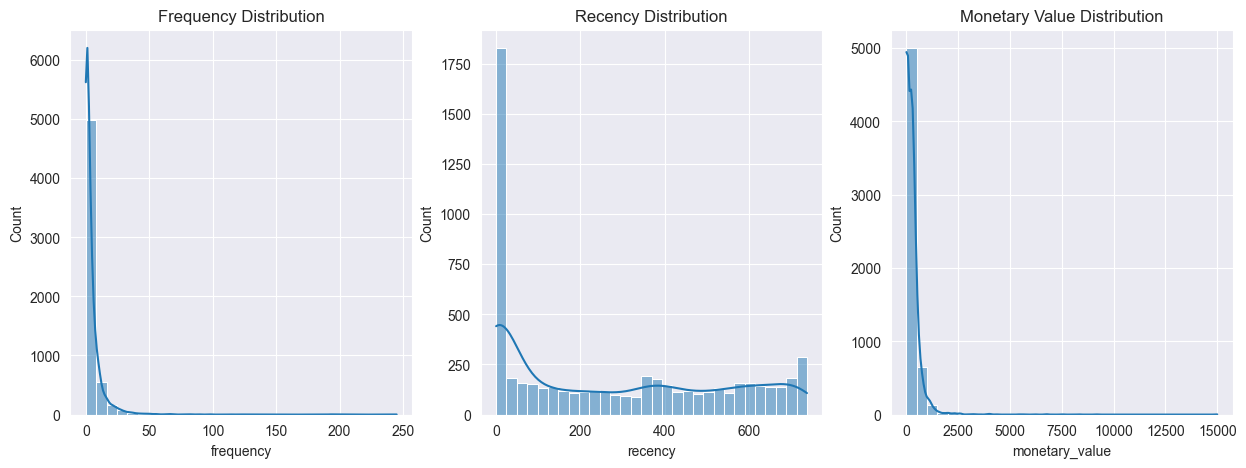

In [23]:
# Check for missing values and basic statistics
print(summary.describe())
print(summary.isnull().sum())

# Plot the distribution of frequency, recency, and monetary value
import seaborn as sns
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(summary['frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(summary['recency'], bins=30, kde=True)
plt.title('Recency Distribution')
plt.subplot(1, 3, 3)
sns.histplot(summary['monetary_value'], bins=30, kde=True)
plt.title('Monetary Value Distribution')
plt.show()


In [24]:
# Add more features to your summary data
summary['avg_order_value'] = summary['monetary_value'] / summary['frequency']
summary['days_between_purchases'] = summary['recency'] / summary['frequency']

# Refit the models with the new features
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
ggf.fit(summary[summary['monetary_value'] > 0]['frequency'], summary[summary['monetary_value'] > 0]['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 4179 subjects, p: 2.10, q: 3.66, v: 508.74>

In [25]:
# Manually search for best penalizer coefficient for BG/NBD
best_bgf = None
best_bgf_score = float('inf')
for penalizer in [0.0, 0.01, 0.1, 1.0]:
    bgf = BetaGeoFitter(penalizer_coef=penalizer)
    bgf.fit(calibration_summary['frequency_cal'], calibration_summary['recency_cal'], calibration_summary['T_cal'])
    holdout_summary['predicted_purchases'] = bgf.predict(holdout_summary['duration_holdout'], 
                                                         holdout_summary['frequency_cal'], 
                                                         holdout_summary['recency_cal'], 
                                                         holdout_summary['T_cal'])
    mae = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
    if mae < best_bgf_score:
        best_bgf_score = mae
        best_bgf = bgf

# Manually search for best penalizer coefficient for Gamma-Gamma
best_ggf = None
best_ggf_score = float('inf')
for penalizer in [0.0, 0.01, 0.1, 1.0]:
    ggf = GammaGammaFitter(penalizer_coef=penalizer)
    ggf.fit(calibration_summary['frequency_cal'], calibration_summary['monetary_value_cal'])
    holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(best_bgf, 
                                                                   holdout_summary['frequency_cal'], 
                                                                   holdout_summary['recency_cal'], 
                                                                   holdout_summary['T_cal'], 
                                                                   holdout_summary['monetary_value_cal'], 
                                                                   time=12, 
                                                                   discount_rate=0.01)
    mae = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
    if mae < best_ggf_score:
        best_ggf_score = mae
        best_ggf = ggf


In [26]:
# Evaluate the best models
holdout_summary['predicted_purchases'] = best_bgf.predict(holdout_summary['duration_holdout'], 
                                                          holdout_summary['frequency_cal'], 
                                                          holdout_summary['recency_cal'], 
                                                          holdout_summary['T_cal'])

holdout_summary['predicted_clv'] = best_ggf.customer_lifetime_value(best_bgf, 
                                                                    holdout_summary['frequency_cal'], 
                                                                    holdout_summary['recency_cal'], 
                                                                    holdout_summary['T_cal'], 
                                                                    holdout_summary['monetary_value_cal'], 
                                                                    time=12, 
                                                                    discount_rate=0.01)

# Calculate accuracy metrics
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
rmse_purchases = mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'], squared=False)
mape_purchases = mean_absolute_percentage_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])

mae_clv = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
rmse_clv = mean_squared_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'], squared=False)
mape_clv = mean_absolute_percentage_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])

print(f'MAE for purchases: {mae_purchases}')
print(f'RMSE for purchases: {rmse_purchases}')
print(f'MAPE for purchases: {mape_purchases}')

print(f'MAE for CLV: {mae_clv}')
print(f'RMSE for CLV: {rmse_clv}')
print(f'MAPE for CLV: {mape_clv}')


MAE for purchases: 1.0
RMSE for purchases: 1.0
MAPE for purchases: 1.0
MAE for CLV: 13973.478613589492
RMSE for CLV: 42805.33445377079
MAPE for CLV: 366.8318900700446


            frequency_holdout  predicted_purchases
CustomerID                                        
12423                     1.0                 -0.0
12433                     1.0                 -0.0
12518                     1.0                 -0.0
12526                     1.0                 -0.0
12662                     1.0                 -0.0
12680                     1.0                 -0.0
12748                     1.0                 -0.0
12985                     1.0                 -0.0
13069                     1.0                 -0.0
13113                     1.0                 -0.0
13426                     1.0                 -0.0
13777                     1.0                 -0.0
14051                     1.0                 -0.0
14422                     1.0                 -0.0
14441                     1.0                 -0.0
14446                     1.0                 -0.0
15311                     1.0                 -0.0
15344                     1.0  

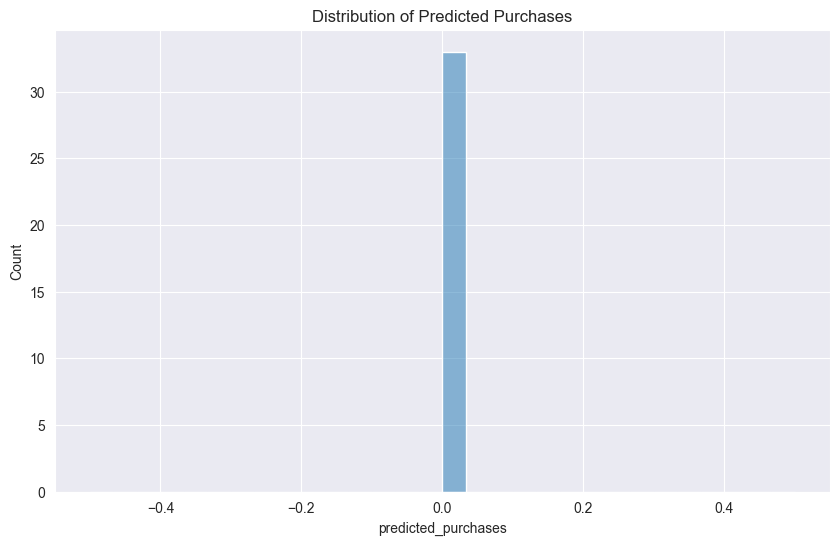

In [27]:
# Check the predicted purchases
print(holdout_summary[['frequency_holdout', 'predicted_purchases']].head(20))

# Plot the distribution of predicted purchases
plt.figure(figsize=(10, 6))
sns.histplot(holdout_summary['predicted_purchases'], bins=30, kde=True)
plt.title('Distribution of Predicted Purchases')
plt.show()


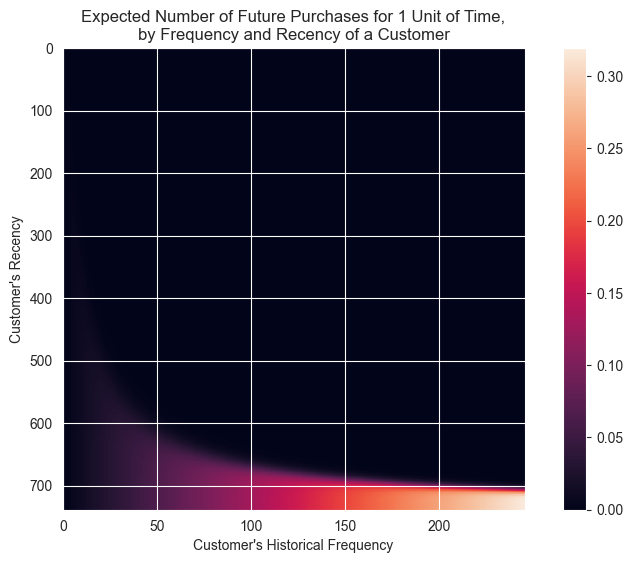

<Figure size 1000x600 with 0 Axes>

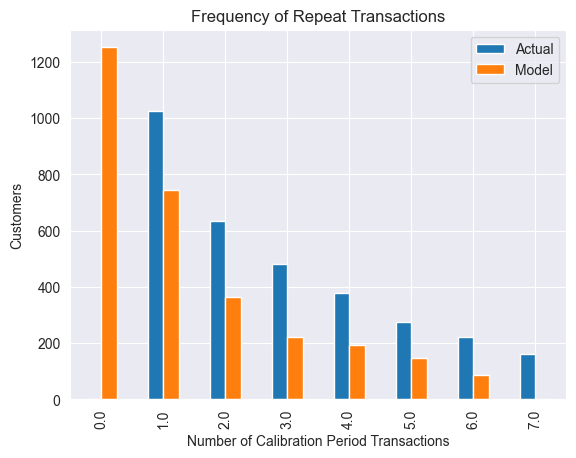

In [28]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_period_transactions

# Plot frequency/recency matrix
plt.figure(figsize=(10, 6))
plot_frequency_recency_matrix(bgf)
plt.show()

# Plot period transactions
plt.figure(figsize=(10, 6))
plot_period_transactions(bgf)
plt.show()


             frequency  recency      T  predicted_purchases_pareto
customer_id                                                       
12346              6.0    196.0  725.0                    0.010651
12347              7.0    402.0  404.0                    0.485184
12348              4.0    363.0  438.0                    0.270543
12349              3.0    571.0  589.0                    0.168573
12350              0.0      0.0  310.0                    0.048325
12351              0.0      0.0  375.0                    0.039808
12352              7.0    356.0  392.0                    0.492009
12353              1.0    204.0  408.0                    0.099277
12354              0.0      0.0  232.0                    0.063537
12355              1.0    353.0  567.0                    0.076255
12356              5.0    402.0  424.0                    0.343599
12357              1.0    355.0  388.0                    0.112110
12358              4.0    730.0  731.0                    0.17

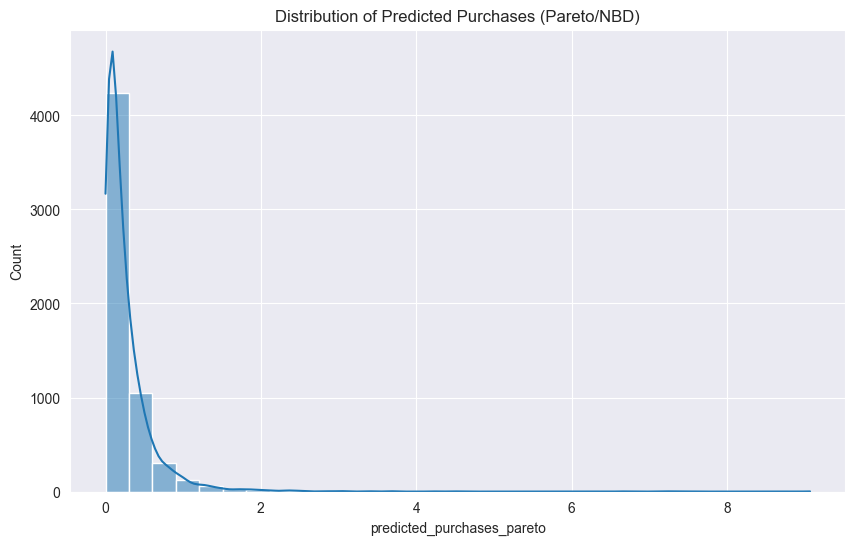

In [29]:
from lifetimes import ParetoNBDFitter

# Fit Pareto/NBD model
pareto_model = ParetoNBDFitter(penalizer_coef=0.0)
pareto_model.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict purchases using Pareto/NBD
summary['predicted_purchases_pareto'] = pareto_model.predict(30, summary['frequency'], summary['recency'], summary['T'])

# Check the predicted purchases
print(summary[['frequency', 'recency', 'T', 'predicted_purchases_pareto']].head(20))

# Plot the distribution of predicted purchases using Pareto/NBD
plt.figure(figsize=(10, 6))
sns.histplot(summary['predicted_purchases_pareto'], bins=30, kde=True)
plt.title('Distribution of Predicted Purchases (Pareto/NBD)')
plt.show()


             frequency  recency      T  predicted_purchases_pareto
customer_id                                                       
12346              6.0    196.0  725.0                    0.010650
12347              7.0    402.0  404.0                    0.485184
12348              4.0    363.0  438.0                    0.270543
12349              3.0    571.0  589.0                    0.168572
12350              0.0      0.0  310.0                    0.048325
12351              0.0      0.0  375.0                    0.039808
12352              7.0    356.0  392.0                    0.492009
12353              1.0    204.0  408.0                    0.099277
12354              0.0      0.0  232.0                    0.063537
12355              1.0    353.0  567.0                    0.076255
12356              5.0    402.0  424.0                    0.343599
12357              1.0    355.0  388.0                    0.112110
12358              4.0    730.0  731.0                    0.17

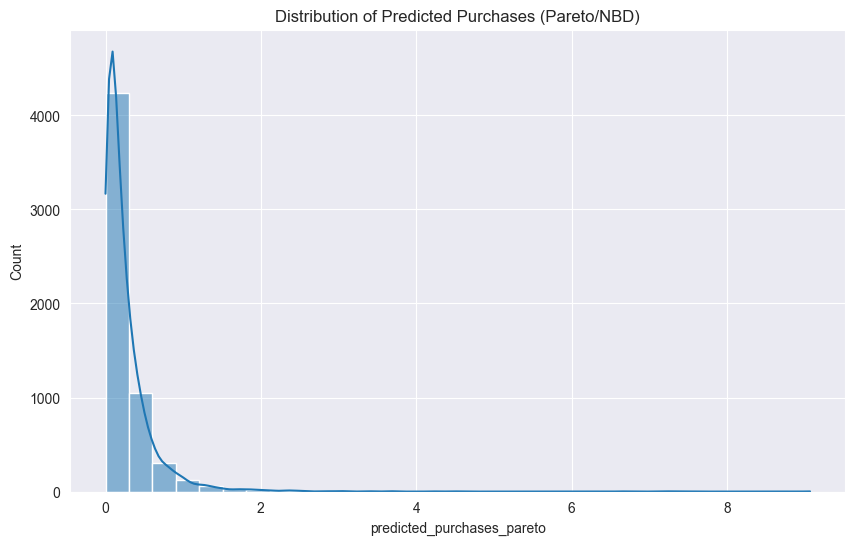

In [30]:
from lifetimes import ParetoNBDFitter

# Fit Pareto/NBD model
pareto_model = ParetoNBDFitter(penalizer_coef=0.0)
pareto_model.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict purchases using Pareto/NBD
summary['predicted_purchases_pareto'] = pareto_model.predict(30, summary['frequency'], summary['recency'], summary['T'])

# Check the predicted purchases
print(summary[['frequency', 'recency', 'T', 'predicted_purchases_pareto']].head(20))

# Plot the distribution of predicted purchases using Pareto/NBD
plt.figure(figsize=(10, 6))
sns.histplot(summary['predicted_purchases_pareto'], bins=30, kde=True)
plt.title('Distribution of Predicted Purchases (Pareto/NBD)')
plt.show()


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate accuracy metrics for the number of purchases
mae_purchases_pareto = mean_absolute_error(summary['frequency'], summary['predicted_purchases_pareto'])
rmse_purchases_pareto = mean_squared_error(summary['frequency'], summary['predicted_purchases_pareto'], squared=False)
mape_purchases_pareto = mean_absolute_percentage_error(summary['frequency'], summary['predicted_purchases_pareto'])

print(f'MAE for purchases (Pareto/NBD): {mae_purchases_pareto}')
print(f'RMSE for purchases (Pareto/NBD): {rmse_purchases_pareto}')
print(f'MAPE for purchases (Pareto/NBD): {mape_purchases_pareto}')


MAE for purchases (Pareto/NBD): 4.373617892049725
RMSE for purchases (Pareto/NBD): 10.4581772551737
MAPE for purchases (Pareto/NBD): 96289308926059.86
